In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import DenseNet121
from sklearn.model_selection import train_test_split

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
x = np.load('/content/drive/MyDrive/AIT 736/ND/resized_images_ND.npy')
y = np.load('/content/drive/MyDrive/AIT 736/ND/labels_ND.npy')

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

# Create DenseNet base
input_shape = x_train.shape[1:]  # Assuming x_train is a numpy array of images
input_shape

(128, 128, 3)

In [12]:
print(x_train.shape)
print(x_test.shape)

(2200, 128, 128, 3)
(550, 128, 128, 3)


In [13]:
def create_densenet_base(input_shape):
    # Load DenseNet model without the top layer
    base_model = DenseNet121(include_top=False, input_shape=input_shape)

    # Perform global average pooling
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a dense layer with 125 sigmoid activated neurons
    x = Dense(125, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_classification_model(base_model, num_classes):
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Add a dense layer with softmax activation for classification
    x = Dense(num_classes, activation='softmax')(base_model.output)

    # Create the classification model
    model = Model(inputs=base_model.input, outputs=x)

    return model

base_model = create_densenet_base(input_shape)

num_classes = 5  # Change this to the number of classes in your classification task
classification_model = create_classification_model(base_model, num_classes)

classification_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati

In [14]:

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("/content/drive/MyDrive/AIT 736/ND/classification_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = classification_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/25
69/69 [==============================] - ETA: 0s - loss: 1.2138 - accuracy: 0.4827
Epoch 1: val_loss improved from inf to 4.24491, saving model to /content/drive/MyDrive/AIT 736/ND/classification_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 96s 352ms/step - loss: 1.2138 - accuracy: 0.4827 - val_loss: 4.2449 - val_accuracy: 0.1782 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - ETA: 0s - loss: 0.9557 - accuracy: 0.5950
Epoch 2: val_loss did not improve from 4.24491
69/69 [==============================] - 10s 145ms/step - loss: 0.9557 - accuracy: 0.5950 - val_loss: 4.4048 - val_accuracy: 0.2127 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - ETA: 0s - loss: 0.7867 - accuracy: 0.6641
Epoch 3: val_loss did not improve from 4.24491
69/69 [==============================] - 10s 139ms/step - loss: 0.7867 - accuracy: 0.6641 - val_loss: 4.5547 - val_accuracy: 0.2127 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.7155
Epoch 4: val_loss improved from 4.24491 to 3.80973, saving model to /content/drive/MyDrive/AIT 736/ND/classification_model.h5
69/69 [==============================] - 14s 209ms/step - loss:

In [15]:
classification_model.load_weights("/content/drive/MyDrive/AIT 736/ND/classification_model.h5")
classification_model.evaluate(x_test, y_test)

18/18 [==============================] - 1s 38ms/step - loss: 0.8384 - accuracy: 0.7618


[0.8384461402893066, 0.7618181705474854]

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming classification_model.predict returns probabilities or predicted classes
y_pred = classification_model.predict(x_test)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)

# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)


18/18 [==============================] - 3s 37ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.83019   0.80734   0.81860       109
           1    0.96000   0.82051   0.88479       117
           2    0.86139   0.84466   0.85294       103
           3    0.57143   0.70796   0.63241       113
           4    0.66019   0.62963   0.64455       108

    accuracy                        0.76182       550
   macro avg    0.77664   0.76202   0.76666       550
weighted avg    0.77710   0.76182   0.76668       550



18/18 [==============================] - 3s 32ms/step


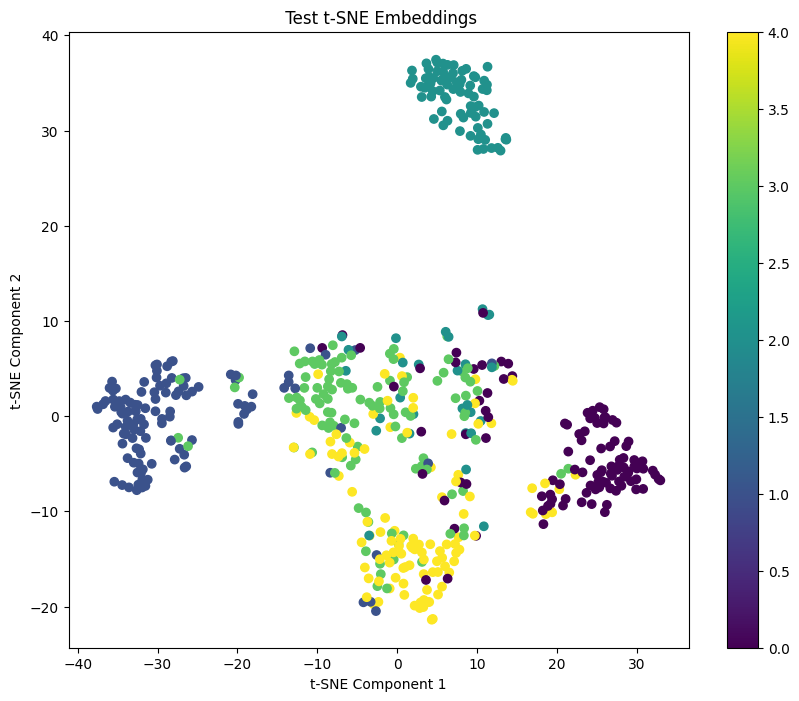

In [17]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


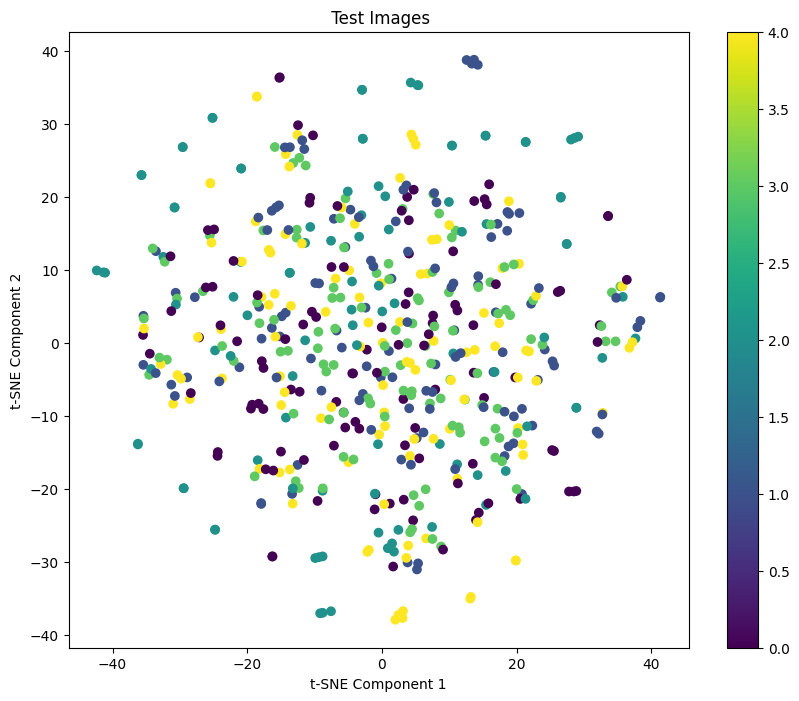

In [18]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
x_test_flat = x_test.reshape((550, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_test_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


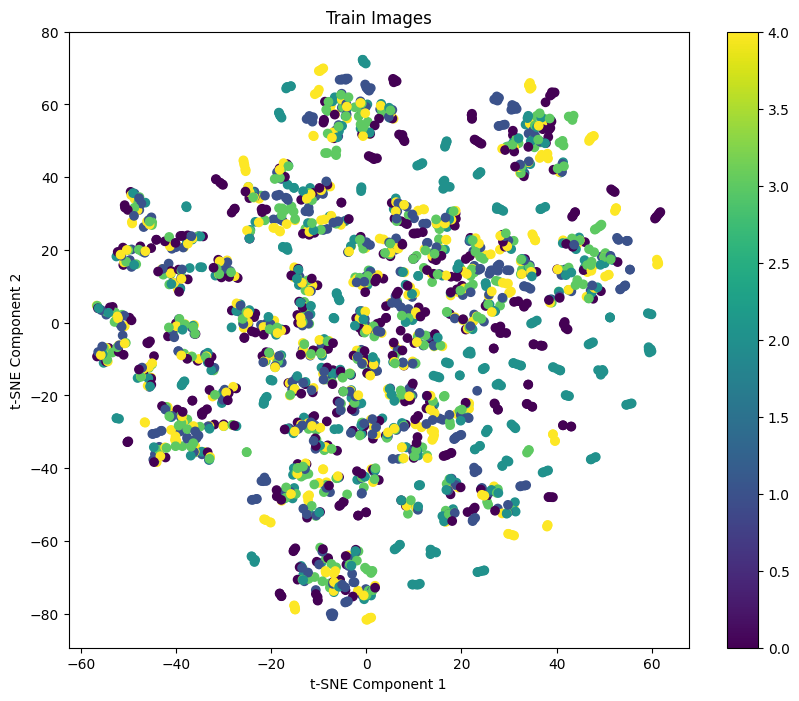

In [19]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
x_train_flat = x_train.reshape((2200, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_train_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


69/69 [==============================] - 2s 29ms/step


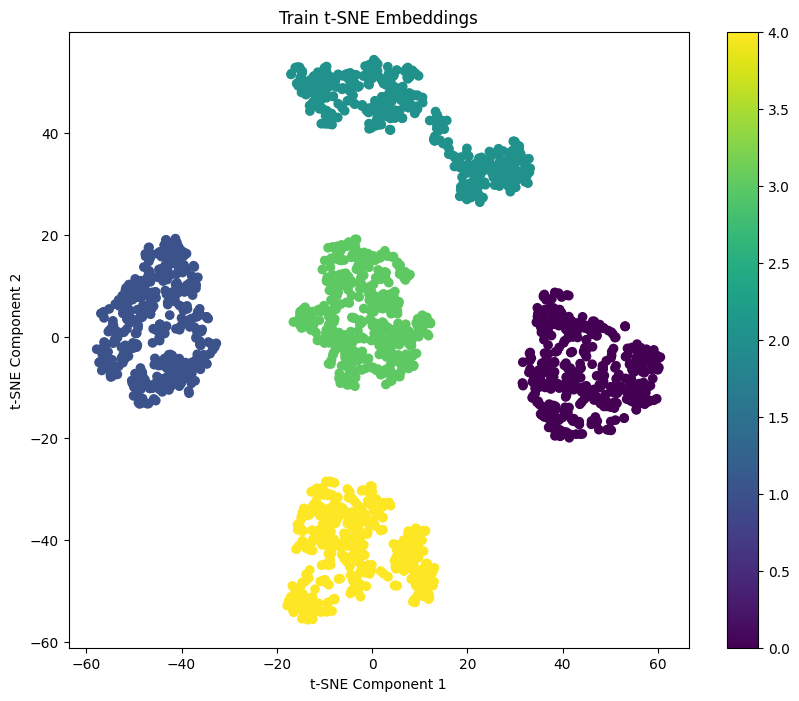

In [20]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


<h1>E-Mixup

In [21]:
xtest_emb = base_model.predict(x_test)
xtrain_emb = base_model.predict(x_train)

69/69 [==============================] - 2s 28ms/step


In [22]:
import keras
y_test_o = keras.utils.to_categorical(y_test)
y_train_o = keras.utils.to_categorical(y_train)
print(y_train_o.shape)
print(y_test_o.shape)

(2200, 5)
(550, 5)


In [23]:
def mixup(xt, yt, mf):
  alp = 0.2
  xaug = []
  yaug = []
  for k in range(0,xt.shape[0]):
    cnt = 0
    for cnt in range(0,mf-1):
      lbd = np.random.beta(alp,alp)
      yks = np.random.randint(xt.shape[0])
      kdash = xt[yks]
      ydash = yt[yks]
      kdash1 = xt[k]
      ydash1 = yt[k]
      xaug1 = kdash1*lbd + kdash*(1-lbd)
      yaug1 = ydash1*lbd + ydash*(1-lbd)
      xaug.append(xaug1)
      yaug.append(yaug1)
  xs2 = np.asarray(xaug)
  ys2 = np.asarray(yaug)
  x1 = np.concatenate((xt,xs2))
  y1 = np.concatenate((yt,ys2))
  return x1,y1

In [24]:
xtrain_emb.shape

(2200, 125)

In [25]:
xtt, ytt = mixup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 2s 6ms/step - loss: 0.2030 - accuracy: 0.9876 - val_loss: 0.7256 - val_accuracy: 0.7655
Epoch 2/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1619 - accuracy: 0.9895 - val_loss: 0.7657 - val_accuracy: 0.7636
Epoch 3/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1528 - accuracy: 0.9871 - val_loss: 0.8017 - val_accuracy: 0.7564
Epoch 4/25
207/207 [==============================] - 1s 3ms/step - loss: 0.1464 - accuracy: 0.9876 - val_loss: 0.8151 - val_accuracy: 0.7618
Epoch 5/25
207/207 [==============================] - 1s 3ms/step - loss: 0.1437 - accuracy: 0.9885 - val_loss: 0.7968 - val_accuracy: 0.7618
Epoch 6/25
207/207 [==============================] - 1s 5ms/step - loss: 0.1413 - accuracy: 0.9873 - val_loss: 0.8267 - val_accuracy: 0.7673
Epoch 7/25
207/207 [==============================] - 1s 5ms/step - loss: 0.1392 - accuracy: 0.9909 - val_loss: 0.8331 - val_accuracy: 0.7618
Epoch 

In [27]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 2ms/step - loss: 1.0401 - accuracy: 0.7673


[1.0401264429092407, 0.7672727108001709]

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.84314   0.78899   0.81517       109
           1    0.92793   0.88034   0.90351       117
           2    0.86869   0.83495   0.85149       103
           3    0.58779   0.68142   0.63115       113
           4    0.65421   0.64815   0.65116       108

    accuracy                        0.76727       550
   macro avg    0.77635   0.76677   0.77049       550
weighted avg    0.77640   0.76727   0.77075       550



E-Stitchup

In [29]:
import numpy as np

def stichup(xt, yt, mf):
    alp = 0.2
    xaug = []
    yaug = []
    for k in range(xt.shape[0]):
        for _ in range(mf-1):  # Renamed loop counter to avoid coAIT 736/NDusion with loop index
            lbd = np.random.beta(alp, alp)
            yks = np.random.randint(xt.shape[0])
            kdash = xt[yks]  # Accessing rows of xt directly
            ydash = yt[yks]  # Accessing corresponding y value
            kdash1 = xt[k]    # Accessing rows of xt directly
            ydash1 = yt[k]    # Accessing corresponding y value
            lbd_stch = int(xt.shape[1] * lbd)
            reff_stich = np.zeros(xt.shape[1])
            for i in range(lbd_stch):
                index_stich = np.random.randint(xt.shape[1])
                reff_stich[index_stich] = 1
            xaug1 = np.zeros(xt.shape[1])  # Initialize as numpy array
            for i in range(len(reff_stich)):
                if reff_stich[i] == 0:
                    xaug1[i] = kdash[i]
                else:
                    xaug1[i] = kdash1[i]
            yaug1 = ydash1 * lbd + ydash * (1 - lbd)
            xaug.append(xaug1)
            yaug.append(yaug1)
    xs2 = np.asarray(xaug)
    ys2 = np.asarray(yaug)
    x1 = np.concatenate((xt, xs2))
    y1 = np.concatenate((yt, ys2))
    return x1, y1


In [30]:
xtt, ytt = stichup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 2s 6ms/step - loss: 0.2724 - accuracy: 0.9370 - val_loss: 0.8588 - val_accuracy: 0.7618
Epoch 2/25
207/207 [==============================] - 1s 5ms/step - loss: 0.2259 - accuracy: 0.9530 - val_loss: 0.8691 - val_accuracy: 0.7491
Epoch 3/25
207/207 [==============================] - 1s 5ms/step - loss: 0.2153 - accuracy: 0.9536 - val_loss: 0.8564 - val_accuracy: 0.7600
Epoch 4/25
207/207 [==============================] - 1s 4ms/step - loss: 0.2077 - accuracy: 0.9620 - val_loss: 0.8748 - val_accuracy: 0.7582
Epoch 5/25
207/207 [==============================] - 1s 4ms/step - loss: 0.2013 - accuracy: 0.9606 - val_loss: 0.9051 - val_accuracy: 0.7564
Epoch 6/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1926 - accuracy: 0.9676 - val_loss: 0.9586 - val_accuracy: 0.7545
Epoch 7/25
207/207 [==============================] - 1s 4ms/step - loss: 0.1843 - accuracy: 0.9705 - val_loss: 0.9273 - val_accuracy: 0.7491
Epoch 

In [32]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 2ms/step - loss: 1.0553 - accuracy: 0.7600


[1.0553146600723267, 0.7599999904632568]

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.83673   0.75229   0.79227       109
           1    0.94340   0.85470   0.89686       117
           2    0.85437   0.85437   0.85437       103
           3    0.57353   0.69027   0.62651       113
           4    0.65421   0.64815   0.65116       108

    accuracy                        0.76000       550
   macro avg    0.77245   0.75996   0.76423       550
weighted avg    0.77281   0.76000   0.76438       550

